**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/forecasting-with-machine-learning).**

---


# Introduction #

Run this cell to set everything up!

In [3]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex6 import *

# Setup notebook
from pathlib import Path
import ipywidgets as widgets
# from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


comp_dir = Path('../input/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

-------------------------------------------------------------------------------

Consider the following three forecasting tasks:

a. 3-step forecast using 4 lag features with a 2-step lead time<br>
b. 1-step forecast using 3 lag features with a 1-step lead time<br>
c. 3-step forecast using 4 lag features with a 1-step lead time<br>

Run the next cell to see three datasets, each representing one of the tasks above.

In [4]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

# 1) Match description to dataset

Can you match each task to the appropriate dataset?

In [5]:
# YOUR CODE HERE: Match the task to the dataset. Answer 1, 2, or 3.
task_a = 2
task_b = 1
task_c = 3
# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [6]:
# Lines below will give you a hint or solution code
#q_1.hint()
q_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

task_a = 2
task_b = 1
task_c = 3

```

-------------------------------------------------------------------------------

Look at the time indexes of the training and test sets. From this information, can you identify the forecasting task for *Store Sales*?

In [6]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08

# 2) Identify the forecasting task for *Store Sales* competition

Try to identify the *forecast origin* and the *forecast horizon*. How many steps are within the forecast horizon? What is the lead time for the forecast?

Run this cell after you've thought about your answer.

In [8]:
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The training set ends on `2017-08-15`, which gives us the forecast origin. The test set comprises the dates `2017-08-16` to `2017-08-31`, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.

Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from `2017-08-15`.


-------------------------------------------------------------------------------

In the tutorial we saw how to create a multistep dataset for a single time series. Fortunately, we can use exactly the same procedure for datasets of multiple series.

# 3) Create multistep dataset for *Store Sales*

Create targets suitable for the *Store Sales* forecasting task. Use 4 days of lag features. Drop any missing values from both targets and features.

In [47]:
# YOUR CODE HERE
y = family_sales.loc[:, 'sales']

# YOUR CODE HERE: Make 4 lag features
X = make_lags(y, lags=4).dropna()
# YOUR CODE HERE: Make multistep target
y = make_multistep_target(y, steps=16).dropna()
y, X = y.align(X, join='inner', axis=0)

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [9]:
# Lines below will give you a hint or solution code
#q_3.hint()
q_3.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

y = family_sales.loc[:, 'sales']

X = make_lags(y, lags=4).dropna()

y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

```

-------------------------------------------------------------------------------

In the tutorial, we saw how to forecast with the MultiOutput and Direct strategies on the *Flu Trends* series. Now, you'll apply the DirRec strategy to the multiple time series of *Store Sales*.

<!-- Make sure you've successfully completed the previous exercise and then run this cell to prepare the data for XGBoost. -->

In [48]:

le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

# 4) Forecast with the DirRec strategy

Instatiate a model that applies the DirRec strategy to XGBoost.

In [49]:
from sklearn.multioutput import RegressorChain

# YOUR CODE HERE
model = RegressorChain(base_estimator=XGBRegressor())

# Check your answer
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [12]:
# Lines below will give you a hint or solution code
#q_4.hint()
q_4.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

from sklearn.multioutput import RegressorChain

model = RegressorChain(base_estimator=XGBRegressor())

```

Run this cell if you'd like to train this model.

In [50]:
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

And use this code to see a sample of the 16-step predictions this model makes on the training data.

NameError: name 'plot_params' is not defined

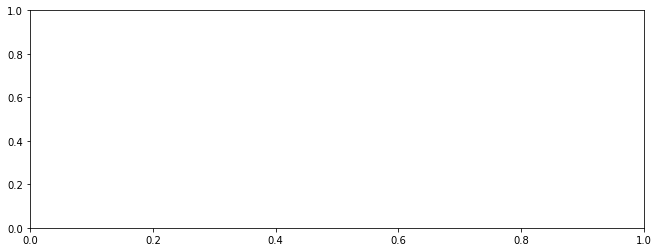

In [51]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

# Next Steps #

Congratulations! You've completed Kaggle's *Time Series* course. If you haven't already, join our companion competition: [Store Sales - Time Series Forecasting](https://www.kaggle.com/c/29781) and apply the skills you've learned.

For inspiration, check out Kaggle's previous forecasting competitions. Studying winning competition solutions is a great way to upgrade your skills.

- [**Corporación Favorita**](https://www.kaggle.com/c/favorita-grocery-sales-forecasting): the competition *Store Sales* is derived from.
- [**Rossmann Store Sales**](https://www.kaggle.com/c/rossmann-store-sales)
- [**Wikipedia Web Traffic**](https://www.kaggle.com/c/web-traffic-time-series-forecasting/)
- [**Walmart Store Sales**](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting)
- [**Walmart Sales in Stormy Weather**](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather)
- [**M5 Forecasting - Accuracy**](https://www.kaggle.com/c/m5-forecasting-accuracy)

# References #

Here are some great resources you might like to consult for more on time series and forecasting. They all played a part in shaping this course:

- *Learnings from Kaggle's forecasting competitions*, an article by Casper Solheim Bojer and Jens Peder Meldgaard.
- *Forecasting: Principles and Practice*, a book by Rob J Hyndmann and George Athanasopoulos.
- *Practical Time Series Forecasting with R*, a book by Galit Shmueli and Kenneth C. Lichtendahl Jr.
- *Time Series Analysis and Its Applications*, a book by Robert H. Shumway and David S. Stoffer.
- *Machine learning strategies for time series forecasting*, an article by Gianluca Bontempi, Souhaib Ben Taieb, and Yann-Aël Le Borgne.
- *On the use of cross-validation for time series predictor evaluation*, an article by Christoph Bergmeir and José M. Benítez.


---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*